# Active learning and semi-supervised learning on image classification

## Prerequisite
You are going to train image classification using Cifar10.<br>
Assume you only have a part of the dataset labeled, while you have a plenty of unlabeled data.<br><br>
Initially you only have 10000 images, with labels.<br>
In this situation, you start the model training with the only dataset you have, and retrain gradually by adding data.<br>
There are three strategies for adding data:
1. Semi-supervised learning: make inference on unlabeled data and add those with high probability as labeled training data.
2. Active learning: add those with high importance as labeled training data, and a human has to label them.
3. Combination of both

## Trying for 3. Combination of active and semi-supervised learning

## This notebook simulates active learning using Cifar10 CNN

### Train a base model

In [1]:
# set Keras backend to Tensorflow
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
kerasBKED = os.environ["KERAS_BACKEND"] 
print(kerasBKED)

tensorflow


In [2]:
# import
import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, InputLayer
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import os
import pickle
import numpy as np

Using TensorFlow backend.
/opt/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
# make saving directory
saveDir = "./cifar10/comb/"
if not os.path.isdir(saveDir):
    os.makedirs(saveDir)

## load Cifar10 images and divide them to inititial, first, second and third sets.
Assuming to train a Cifar10 CNN model with data increasing gradually, I get the following datasets:
- initial training set: 10000 images
- unlabeled training set: 40000 images
- test set: 10000 images

In [4]:
# get Cifar10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('x train shape:', x_train.shape)
print(x_train.shape[0], 'training images')
print(x_test.shape[0], 'test images')

x train shape: (50000, 32, 32, 3)
50000 training images
10000 test images


In [5]:
# prerequisite
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [6]:
initNum = 10000
x_train1 = x_train[:initNum]
y_train1 = y_train[:initNum]
remainXTrain = x_train[initNum:]
remainYTrain = y_train[initNum:]

In [7]:
print("initial training X: {0}\n\
initial training Y: {1}\n\
remaining training X: {2}\n\
remaining training Y: {3}\n\
test X: {4}\n\
test Y: {5}".format(
    x_train1.shape,y_train1.shape,remainXTrain.shape,remainYTrain.shape,x_test.shape,y_test.shape))

initial training X: (10000, 32, 32, 3)
initial training Y: (10000, 10)
remaining training X: (40000, 32, 32, 3)
remaining training Y: (40000, 10)
test X: (10000, 32, 32, 3)
test Y: (10000, 10)


In [8]:
labels = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

## Define the CNN model in Keras

In [9]:
# optimization and compile
def compileModel(model, lr=0.001, decay=1e-6):
    opt = keras.optimizers.adam(lr=lr, decay=decay)

    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model

In [10]:
# define layers
def getModel(loadModel=False, modelFilePath="", lr=0.001, decay=1e-6):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    model = compileModel(model)
    
    # load model weights if specified
    if loadModel == True:
        model.load_weights(modelFilePath)
    
    return model

In [11]:
# get the newest model file
def getNewestModel(dirname=saveDir):
    import os
    from glob import glob
    target = os.path.join(dirname, '*')
    files = [(f, os.path.getmtime(f)) for f in glob(target)]
    if len(files) == 0:
        return getModel()
    else:
        newestModel = sorted(files, key=lambda files: files[1])[-1]
        return getModel(True, newestModel[0])

In [12]:
# get the CNN model
model = getModel()

In [13]:
# train the model
def trainModel(model, xTrain, yTrain, xTest, yTest, batch_size=50, epochs=100, patience=1):
    es_cb = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='auto')
    chkpt = os.path.join(saveDir, 'Cifar10_.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5')
    cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

    # train
    model.fit(xTrain, yTrain,
              batch_size=batch_size,
              epochs=epochs,
              verbose=0,
              validation_data=(xTest, yTest),
              callbacks=[es_cb, cp_cb],
              shuffle=True)
    return model

### Training the model for the initial dataset

In [14]:
# run training on the initial dataset

# model = trainModel(model, x_train1, y_train1, x_test, y_test, patience=2)

In [15]:
# use the pre-trained model, with 65% accuracy on test data

model.load_weights("./cifar10/Cifar10_.01-0.75-1.03.hdf5")

In [16]:
# define evaluation method
def evaluate(model, xTest, yTest, display=False):
    # only shows loss and accuracy
    if display == False:
        ev = model.evaluate(xTest, yTest, verbose=0)
        return ev
    # shows confusion matrix, classification report and accuracy score
    else:
        import pandas as pd
        import seaborn as sn
        import matplotlib.pyplot as plt
        from sklearn.metrics import confusion_matrix
        from sklearn.metrics import classification_report, accuracy_score

        def toNum(y):
            yNum = []
            for x in y:
                yNum.append(x.argmax())
            return np.array(yNum)

        # visualize confusion matrix on heat map
        def print_cmx(y_true, y_pred):
            labels = sorted(list(set(y_true)))
            cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

            df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

            plt.figure(figsize = (10,7))
            sn.heatmap(df_cmx, annot=True)
            plt.show()

        # reshape testing target to fit to scikit-learn metric form
        y_testPred = model.predict(xTest)
        y_testP = toNum(y_testPred)
        y_true = toNum(yTest)

        # get confusion matrix, classification report and accuracy score
        print_cmx(y_true, y_testP)
        print(classification_report(y_true, y_testP))
        print("Accuracy: {0}".format(accuracy_score(y_true, y_testP)))

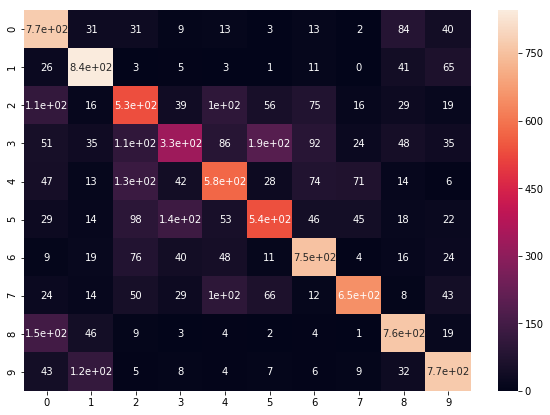

             precision    recall  f1-score   support

          0       0.61      0.77      0.68      1000
          1       0.74      0.84      0.79      1000
          2       0.51      0.53      0.52      1000
          3       0.52      0.33      0.40      1000
          4       0.58      0.57      0.58      1000
          5       0.60      0.54      0.57      1000
          6       0.69      0.75      0.72      1000
          7       0.79      0.65      0.71      1000
          8       0.73      0.77      0.74      1000
          9       0.74      0.77      0.75      1000

avg / total       0.65      0.65      0.65     10000

Accuracy: 0.6537


In [17]:
# evaluate the initial test dataset
evaluate(model, x_test, y_test, display=True)

In [18]:
# record the loss and accuracy
evalHistory = []
evalHistory.append(evaluate(model, x_test, y_test, display=False))
print(evalHistory[-1])

[1.0257026025772096, 0.65369999999999995]


## Now let's use the trained model for active learning

In [19]:
# get a list of low margin inference
def getLowMargin(proba, bound=0.01):
    ls = []
    for i in range(len(proba)):
        margin = proba[i][np.argsort(proba[i])][-1] - proba[i][np.argsort(proba[i])][-2]
        if margin < bound:
            ls.append([i,margin])
    return ls

In [20]:
# get a list of high probability inference
def getHighProb(proba, bound):
    ls = []
    for i in range(len(proba)):
        for p in range(len(proba[i])):
            if proba[i,p] > bound:
                ls.append([i,p])
    return ls

In [21]:
# concatenate initial training data with low margin of 1st and 2nd choice inference and high probability
# removing them from remaining data
def concatData(proba, remainX, remainY, xTrain, yTrain, Lbound=0.01, Hbound=0.99):
    lm = getLowMargin(proba, Lbound)
    print("number of data with first and second choice probability lower than {0}: {1}".format(Lbound,len(lm)))
    hp = getHighProb(proba, Hbound)
    print("number of data with probability higher than {0}: {1}".format(Hbound,len(hp)))
    
    nlm = np.array(np.array(lm)[:,0], dtype="int32")
    lxAdd = remainX[nlm]
    lyAdd = remainY[nlm]
    print("x shape to be added from low margin: {0}\ny shape to be added: {1}".format(lxAdd.shape, lyAdd.shape))
    
    nhp = np.array(hp)
    hxAdd = remainX[nhp[:,0]]
    hyAdd = np.array([nhp[:,1]]).T
    hyAdd = keras.utils.to_categorical(hyAdd, num_classes)
    yActual = remainY[nhp[:,0]]
    print("x shape to be added from high probability: {0}\ny shape to be added: {1}".format(hxAdd.shape, hyAdd.shape))
    
    ixAdd = np.vstack((lxAdd, hxAdd))
    iyAdd = np.vstack((lyAdd, hyAdd))
    nlmhp = np.hstack((nhp[:,0],nlm))
    
    NewXTrain = np.vstack((xTrain, ixAdd))
    NewYTrain = np.vstack((yTrain, iyAdd))
    print("new training data:\n\tx: {0}\n\ty: {1}".format(NewXTrain.shape, NewYTrain.shape))
    
    remainX2 = np.delete(remainX, nlmhp, axis=0)
    remainY2 = np.delete(remainY, nlmhp, axis=0)
    print("remaining data:\n\tx: {0}\n\ty: {1}".format(remainX2.shape, remainY2.shape))
        
    yEval = [[yActual[i],hyAdd[i]] for i in range(len(hyAdd))]
    
    return remainX2, remainY2, NewXTrain, NewYTrain, yEval

In [22]:
def getError(yEval):
    errLabel = [0]*10
    for i in range(len(yEval)):
        if False in (yEval[i][0] == yEval[i][1]):
            errLabel[np.argmax(yEval[i][0]-yEval[i][1])] += 1
    return errLabel

In [23]:
proba = model.predict_proba(remainXTrain, verbose=0)

In [24]:
# get new training data from high probability
remainXTrain, remainYTrain, x_train2, y_train2, yEval= concatData(proba, 
                                                                  remainXTrain, 
                                                                  remainYTrain, 
                                                                  x_train1, 
                                                                  y_train1, 
                                                                  0.01,
                                                                  0.9999)
errPred = getError(yEval)

number of data with first and second choice probability lower than 0.01: 536
number of data with probability higher than 0.9999: 611
x shape to be added from low margin: (536, 32, 32, 3)
y shape to be added: (536, 10)
x shape to be added from high probability: (611, 32, 32, 3)
y shape to be added: (611, 10)
new training data:
	x: (11147, 32, 32, 3)
	y: (11147, 10)
remaining data:
	x: (38853, 32, 32, 3)
	y: (38853, 10)


In [25]:
# retrain the model
model = trainModel(model, x_train2, y_train2, x_test, y_test)

Epoch 00001: val_loss improved from inf to 0.99271, saving model to ./cifar10/comb/Cifar10_.01-0.66-0.99.hdf5
Epoch 00002: val_loss improved from 0.99271 to 0.98369, saving model to ./cifar10/comb/Cifar10_.02-0.60-0.98.hdf5
Epoch 00003: val_loss did not improve
Epoch 00003: early stopping


In [26]:
# load the newest checkpoint model to get the best accuracy one
model = getNewestModel()

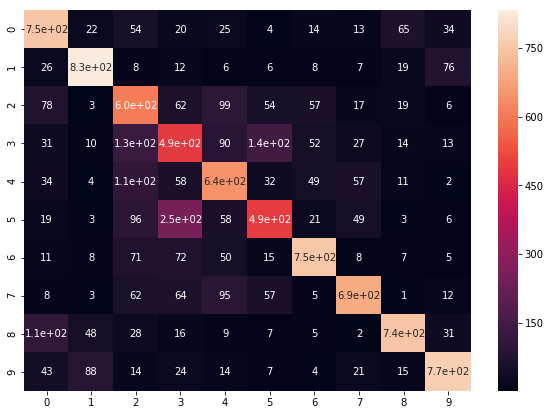

             precision    recall  f1-score   support

          0       0.68      0.75      0.71      1000
          1       0.81      0.83      0.82      1000
          2       0.51      0.60      0.56      1000
          3       0.46      0.49      0.47      1000
          4       0.59      0.65      0.62      1000
          5       0.60      0.49      0.54      1000
          6       0.78      0.75      0.77      1000
          7       0.78      0.69      0.73      1000
          8       0.83      0.74      0.78      1000
          9       0.81      0.77      0.79      1000

avg / total       0.68      0.68      0.68     10000

Accuracy: 0.6775


In [27]:
# evaluate with the initial test dataset
evaluate(model, x_test, y_test, display=True)

In [28]:
# record the loss and accuracy
evalHistory.append(evaluate(model, x_test, y_test, display=False))
print(evalHistory[-1])

[0.98369003400802613, 0.67749999999999999]


### repeat active learning for 10 times

In [29]:
for i in range(10):
    proba = model.predict_proba(remainXTrain, verbose=0)
    # get new training data from high probability
    remainXTrain, remainYTrain, x_train2, y_train2, yEval= concatData(proba, 
                                                                      remainXTrain, 
                                                                      remainYTrain, 
                                                                      x_train2, 
                                                                      y_train2, 
                                                                      0.01,
                                                                      0.9999)
    errPred2 = getError(yEval)
    errPred = [errPred2[i]+errPred[i] for i in range(len(errPred))]
    model = trainModel(model, x_train2, y_train2, x_test, y_test)
    model = getNewestModel()
    evalHistory.append(evaluate(model, x_test, y_test, display=False))
    print("\nAfter Iter: {0}\n\tLoss and Acc: {1}\n".format(i,evalHistory[-1]))

number of data with first and second choice probability lower than 0.01: 449
number of data with probability higher than 0.9999: 559
x shape to be added from low margin: (449, 32, 32, 3)
y shape to be added: (449, 10)
x shape to be added from high probability: (559, 32, 32, 3)
y shape to be added: (559, 10)
new training data:
	x: (12155, 32, 32, 3)
	y: (12155, 10)
remaining data:
	x: (37845, 32, 32, 3)
	y: (37845, 10)
Epoch 00001: val_loss improved from inf to 0.96043, saving model to ./cifar10/comb/Cifar10_.01-0.58-0.96.hdf5
Epoch 00002: val_loss did not improve
Epoch 00002: early stopping

After Iter: 0
	Loss and Acc: [0.96043149595260624, 0.67310000000000003]

number of data with first and second choice probability lower than 0.01: 462
number of data with probability higher than 0.9999: 320
x shape to be added from low margin: (462, 32, 32, 3)
y shape to be added: (462, 10)
x shape to be added from high probability: (320, 32, 32, 3)
y shape to be added: (320, 10)
new training data:


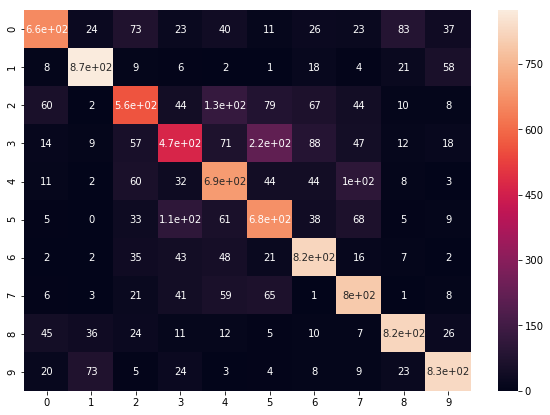

             precision    recall  f1-score   support

          0       0.79      0.66      0.72      1000
          1       0.85      0.87      0.86      1000
          2       0.64      0.56      0.60      1000
          3       0.59      0.47      0.52      1000
          4       0.62      0.69      0.66      1000
          5       0.60      0.68      0.64      1000
          6       0.73      0.82      0.78      1000
          7       0.71      0.80      0.75      1000
          8       0.83      0.82      0.83      1000
          9       0.83      0.83      0.83      1000

avg / total       0.72      0.72      0.72     10000

Accuracy: 0.7204


In [30]:
# evaluate the initial test dataset
evaluate(model, x_test, y_test, display=True)

## wrap up the combination of active and semi-supervised learning

In [31]:
# show remaining data in each label
remainLabel = [0]*10
for y in remainYTrain:
    remainLabel[np.argmax(y)] += 1
remainLabel

[3290, 2144, 3333, 3287, 3423, 3387, 3022, 2711, 2612, 2762]

In [32]:
# show data in each label used on training
usedLabels = [5000-i for i in remainLabel]
usedLabels

[1710, 2856, 1667, 1713, 1577, 1613, 1978, 2289, 2388, 2238]

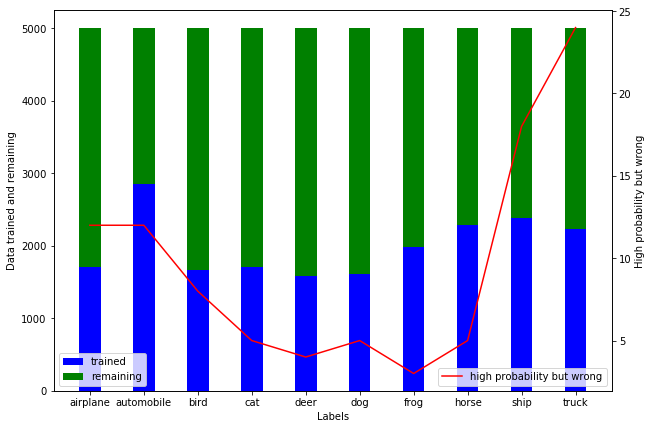

In [33]:
# show graph for the data used, remaining and number of errors with high probability prediction on each label
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize = (10,7))
ax2 = ax1.twinx()

w = 0.4
l1 = list(range(10))

ax1.bar(l1, usedLabels, align='center', color="blue", width=w, label='trained')
ax1.bar(l1, remainLabel, align='center', color="green", width=w, label='remaining', bottom=usedLabels)
ax2.plot(errPred,  color="red", label='high probability but wrong')
ax1.legend(loc="lower left")
ax2.legend(loc="lower right")
ax1.set_xlabel("Labels")
ax1.set_ylabel("Data trained and remaining")
ax2.set_ylabel("High probability but wrong")

plt.xticks(l1, labels)
plt.show()

In [36]:
for i in range(10):
    print("{0}:\t{1}% wrong label added".format(labels[i], round((errPred[i]/usedLabels[i])*100, 3)))

airplane:	0.702% wrong label added
automobile:	0.42% wrong label added
bird:	0.48% wrong label added
cat:	0.292% wrong label added
deer:	0.254% wrong label added
dog:	0.31% wrong label added
frog:	0.152% wrong label added
horse:	0.218% wrong label added
ship:	0.754% wrong label added
truck:	1.072% wrong label added


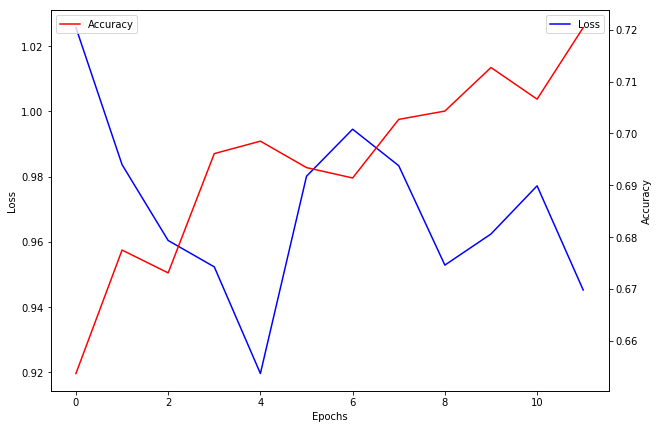

In [34]:
# show evaluation history
npeh = np.array(evalHistory)
fig, ax1 = plt.subplots(figsize=(10,7))
epochHis = list(range(12))
ax1.plot(epochHis, npeh[:,0], "b", label="Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

ax2 = ax1.twinx()
ax2.plot(epochHis, npeh[:,1], "r", label="Accuracy")
ax2.set_ylabel("Accuracy")
ax2.legend()

plt.show()